In [17]:
from google.colab import drive # pour importer le dataset depuis drive
import pandas as pd # pr manipuler les dataframes
import numpy as np # pour créer des matrices
import matplotlib.pyplot as plt # pour tracer des graphiques
import seaborn as sns # pour la visualisation de la data

In [18]:
drive.mount('/content/drive')
df= pd.read_csv('/content/drive/MyDrive/Projet-MachineLearning/creditcard.csv') # chemin vers le dataset
#print(dataset.head())
print(df.shape)
print(df.columns)
print(df.head)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
(284807, 31)
Index(['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
       'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount',
       'Class'],
      dtype='object')
<bound method NDFrame.head of             Time         V1         V2        V3        V4        V5  \
0            0.0  -1.359807  -0.072781  2.536347  1.378155 -0.338321   
1            0.0   1.191857   0.266151  0.166480  0.448154  0.060018   
2            1.0  -1.358354  -1.340163  1.773209  0.379780 -0.503198   
3            1.0  -0.966272  -0.185226  1.792993 -0.863291 -0.010309   
4            2.0  -1.158233   0.877737  1.548718  0.403034 -0.407193   
...          ...        ...        ...       ...       ...       ...   
284802  172786.0 -11.881118  10.071785 -9.834783 -2.066656 

## Le dataset
Ce dataset de données provient de Kaggle et contient des informations sur des transactions effectuées par des cartes de crédit européene en septembre 2013.
Les caractéristiques du dataset sont principalement des variables numériques obtenues via une analyse en composantes principales, ce qui signifie que les informations d'origine ont été transformées pour protéger la confidentialité des données.
Voici les différentes colonnes:
- V1 à V28 : Composantes principale issus de la PCA
- Time : Temps écoulé en secondes entre chaque transaction et la première transaction dans le jeu de données.
- Amount : Montant de la transaction
- Class : Variable cible indiquant si la transaction est frauduleuse (1) ou non (0).

Class
0    0.998273
1    0.001727
Name: proportion, dtype: float64
(284807, 31)


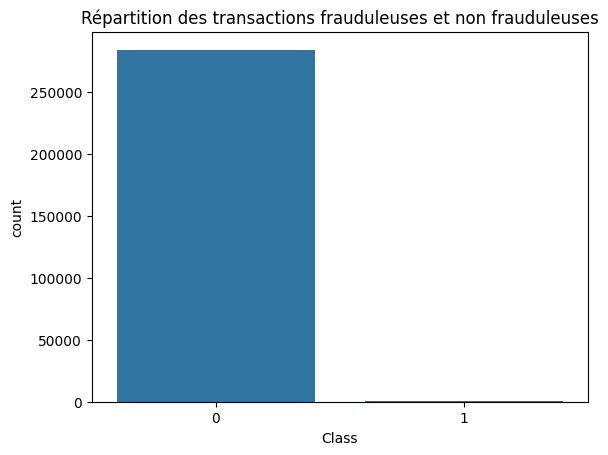

In [19]:
print(df["Class"].value_counts(normalize=True))
print(df.shape)
sns.countplot(x="Class", data=df)
plt.title("Répartition des transactions frauduleuses et non frauduleuses")
plt.show()

## -> Problème
Notre ensemble de donnée contient beaucoup plus de transactions non frauduleuses que de transactios frauduleuses. => Les classes sont extremement déséquilibrées.

-> SMOTE

SMOTE est une technique de suréchantillonnage qui crée des exemples synthétiques de la classe minoritaire (transactios frauduleuses) afin d'équilibrer l'ensemble des données. Il fonctionne en trouvant les k plus proche voisins (knn) (distance euclidienne) et en créant un nouvel exemple le long de la ligne joignant l'exemple minoritaire et l'un de ses voisins.

### Paramètre Le surechantillonage

Il est possible de controler le taux de suréchantillonnage à l'aide de 3 arguments:
- sampling_strategy
Cet argument permet de controler le ratio entre la classe minoritaire et la classe majoritaire après le suréchantillonnage. Il permet en gros de définir le niveau d'équilibre que l'on soubaite atteindre entre les classes.

-  k_neighbors
Cet argument controle le nombre de voisins les plus proches utilisées par SMOTE pour créer de nouveaux échantillons synthétiques. Il est définit à 5 par défaut

(341178, 31)
Class
0    0.833333
1    0.166667
Name: proportion, dtype: float64


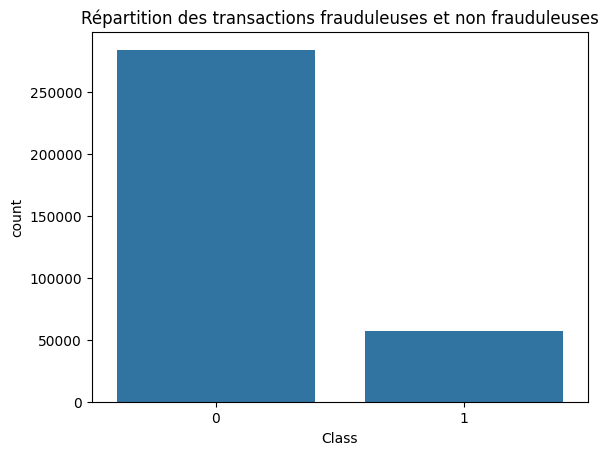

In [20]:
# import bibliothèques nécessaires au SMOTE
from imblearn.over_sampling import SMOTE
# contient la fonction smote()
from sklearn.model_selection import train_test_split
# pour diviser les donnéees d'entrainement et de test
from sklearn.metrics import classification_report

# Charger l'ensemble de données et divisez-le
X = df.drop('Class', axis=1 )
y = df['Class']

# Appliquer SMOTE à l'ensemble de formation
smote = SMOTE(random_state=42, sampling_strategy=0.2)
X_resampled, y_resampled = smote.fit_resample(X, y)
"""
La fonction fit_resemble a besoin à la fois des caractéristiques et de la variable cible pour effectuer
le suréchantillonnage. Les caractéristiques (x) aident SMOTE à identifier le voisinage des échantillons
de la classe minoritaire, tandis que la variable cible (y) spécifie quels échantillons appartiennt
à la classe minoritaire.
"""
resampled_df = pd.concat([pd.DataFrame(X_resampled), pd.DataFrame(y_resampled)], axis=1)
resampled_df.rename(columns={0: 'Class'}, inplace=True)  # Remplace 0 par le nom original de la colonne si différent
print(resampled_df.shape)
print(resampled_df["Class"].value_counts(normalize=True))
sns.countplot(x="Class", data=resampled_df)
plt.title("Répartition des transactions frauduleuses et non frauduleuses")
plt.show()

Et voila on se retrouve maintenant avec des données plus équilibrés. Mais attention au biais !

### Prédiction à l'aide du théorème de Bayes

Pour rappel, d'après le théorème de Bayes: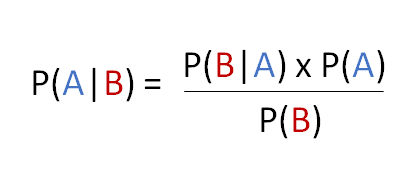

Dans notre cas:
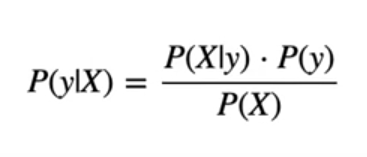

In [21]:
import plotly.express as px
resampled_df
fig = px.scatter(resampled_df, x='Amount', y='Class')
fig.show()

On remarque avec ce graphique les transactions frauduleuses se font sur de bien plus petit montant [0- 2000] que les transactions non frauduleuse.

In [22]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X_resampled, y_resampled, test_size=0.2, random_state=0
)

## Prédiction en utilisant le modèle GaussianNB

GaussianNB() est un classificateur basé sur le théorème de Bayes, avec une forte supposition (naive) d'indépendance entre les caractéristiques. Il calcul la probabilité qu'une observation appartienne à une classe donnée, en se basant sur la probabilité de chaque caractéristique dans cette classe.
Ce modèle utilise la distribution gaussienne pour modéliser les probabilités conditionnelles des caractéristiques.
L'hypothèse "naive" esr que les caractéristiques sont indépendantes les unes des autres, étant donné la classe. Cela signifie que le modèle ne prend pas en compte les relations ou les dépendances entre les caractéristiques.

Avantage:
- Simple à comprendre et à implémenter
- Efficace en termes de calcul, surtout avec un grand nombre de caractéristiques.
- Performant dans de nombreux cas, meme avec l'hypothèse "naive".
Inconvénient:
- L'hypothèse d'indépendance peut etre restrictive dans certains cas.
- Peut etre moins performant que des modèles plus complexes si les caractéristiques sont fortement corrélées.

In [23]:
from sklearn.naive_bayes import GaussianNB

model = GaussianNB()
model.fit(X_train, y_train)
predicted = model.predict(X_test)

print("Actual Value:", y_test)
print("Predicted Value:", predicted)

Actual Value: 246321    0
57451     0
206307    0
235867    0
42111     0
         ..
18940     0
66238     0
158939    0
158383    0
20556     0
Name: Class, Length: 68236, dtype: int64
Predicted Value: [0 0 0 ... 0 0 0]


In [24]:
from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    ConfusionMatrixDisplay,
    f1_score,
)
y_pred = model.predict(X_test)
accuray = accuracy_score(y_pred, y_test)
f1 = f1_score(y_pred, y_test, average="weighted")
print("Accuracy:", accuray)
print("F1 Score:", f1)

Accuracy: 0.9463333137933055
F1 Score: 0.9495207294029043


# Matrice de confusion

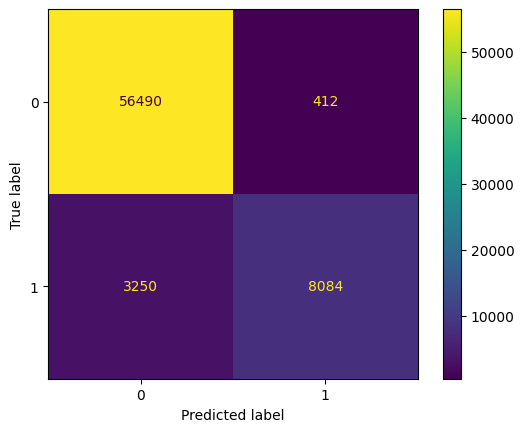

In [25]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
disp.plot()
plt.show()

### Pour aller plus loin:
- Inférence Bayésienne:
Pour obtenir une distribution postérieure des paramètres du modèle et quantifier l'incertitude des prédictions.
- Evaluer les performances du modèle de manière bayésienne
Metrique: Log-likelihood, deviance information criterion (DIC), Watanabe-Akaike Information Criterion (WAIC)


## Test avec du sous-echantillonnage


Class
0    0.998273
1    0.001727
Name: proportion, dtype: float64
(284807, 31)


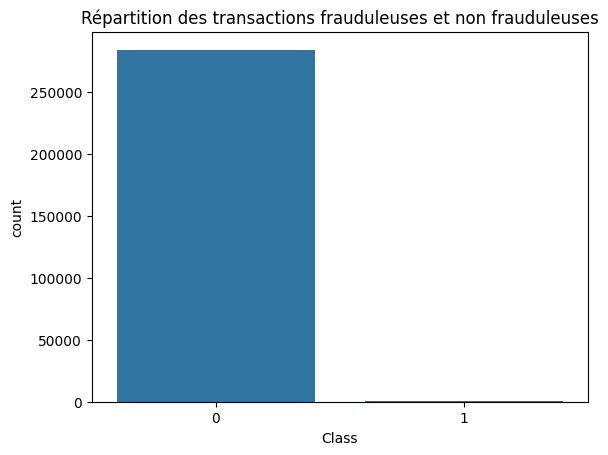

In [26]:
print(df["Class"].value_counts(normalize=True))
print(df.shape)
sns.countplot(x="Class", data=df)
plt.title("Répartition des transactions frauduleuses et non frauduleuses")
plt.show()

X = df.drop('Class', axis=1 )
y = df['Class']

In [27]:
from imblearn.under_sampling import RandomUnderSampler
# lib pour le sous-échantillonnage
from collections import Counter
# pour compter la fréquence des échantillons dans chaque classe

Distribution des classes avant le sous-échantillonnage : Counter({0: 284315, 1: 492})
Distribution des classes après le sous-échantillonnage : Counter({0: 2460, 1: 492})
(2952, 31)
Class
0    0.833333
1    0.166667
Name: proportion, dtype: float64


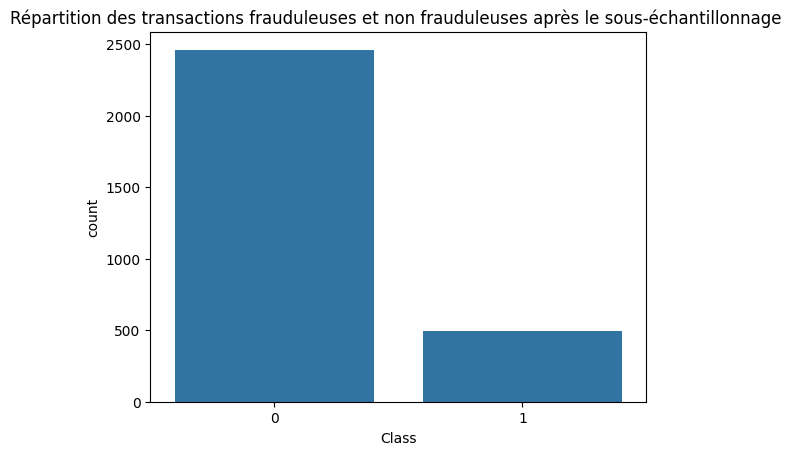

In [28]:
rus = RandomUnderSampler(random_state=42, sampling_strategy=0.2)
X_res, y_res = rus.fit_resample(X, y)
print('Distribution des classes avant le sous-échantillonnage :', Counter(y))
print('Distribution des classes après le sous-échantillonnage :', Counter(y_res))

resampled_df = pd.concat([pd.DataFrame(X_res), pd.DataFrame(y_res)], axis=1)
resampled_df.rename(columns={0: 'Class'}, inplace=True)
print(resampled_df.shape)
print(resampled_df["Class"].value_counts(normalize=True))
sns.countplot(x="Class", data=resampled_df)
plt.title("Répartition des transactions frauduleuses et non frauduleuses après le sous-échantillonnage ")
plt.show()

In [29]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X_res, y_res, test_size=0.2, random_state=0
)
from sklearn.naive_bayes import GaussianNB

model = GaussianNB()
model.fit(X_train, y_train)
predicted = model.predict(X_test)

print("Actual Value:", y_test)
print("Predicted Value:", predicted)
from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    ConfusionMatrixDisplay,
    f1_score,
)
y_pred = model.predict(X_test)
accuray = accuracy_score(y_pred, y_test)
f1 = f1_score(y_pred, y_test, average="weighted")
print("Accuracy:", accuray)
print("F1 Score:", f1)

Actual Value: 187187    0
152223    1
163882    0
88876     1
94102     0
         ..
130054    0
10498     1
72740     0
29577     0
137969    0
Name: Class, Length: 591, dtype: int64
Predicted Value: [0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 1 0 0 0 0 0 1 0 0 0 0 0
 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 1 0 0 0 0 0 0 0 1 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 1 0 0 1 0 0 0 0 1 0 0 0 1 0 0 0 1
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 1 1
 0 0 0 0 1 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0
 1 1 0 0 0 0 0 0 0 1 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0 0 0 0 0 1 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 1 0 0 0 0 1 0 0 0 0
 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1

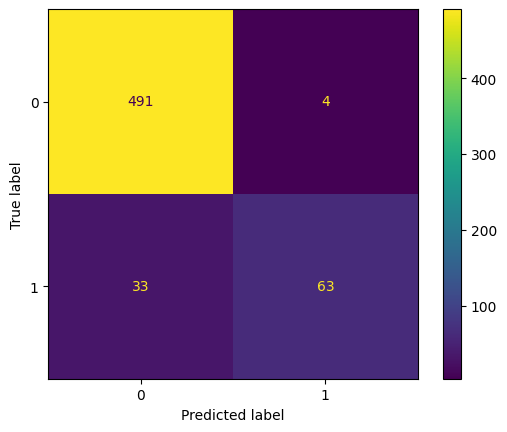

In [30]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
disp.plot()
plt.show()